# Importing the goodies

In [0]:
from tqdm.notebook import tqdm

import numpy as np
from numpy import moveaxis
import torch
from torch.utils.data.sampler import Sampler
from torch.utils.data import TensorDataset 
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn                                                
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
import time
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
import cv2
from torchsummary import summary
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import pandas as pd
classes = [
           "gastrula",
           "comma",
           "fold",
           "l1"
]
ROOT = "/content/drive/My Drive/kaggle/GSOC/"

## Parallel CNNs
Two models having intentionally different architectures leads to them having different confusion matrices (i.e different weak areas when classifying). But when the 2 models are combined using a third class wrapper and a few more linear layers, they tend to neutralise each other’s weaknesses

<img src= "parallel_cnn.jpg" />


### Pros of using this technique are:



*    By combining the strengths of two different CNNs. We can make a robust model that can learn from two different versions of the same image (as seen in figure 6).
*   High accuracy with a relatively small architecture.


## Copying and extracting training data

* `v` in the `-xvf` means verbose
* `-C` in between the paths means it'll move to the directory of the tar file before extracting 

In [4]:
!cp --verbose /content/drive/"My Drive"/kaggle/GSOC/train_images.tar.gz /content/ 

'/content/drive/My Drive/kaggle/GSOC/train_images.tar.gz' -> '/content/train_images.tar.gz'


In [0]:
!mkdir raw_images
!tar -xvf  /content/train_images.tar.gz -C /content/raw_images/

# Custom class to load up that training data
* they're the same training data as use in c_elegans_lifecycle.ipynb


In [0]:
def img_to_arr(im_path):
    # print(im_path)
    img = cv2.imread(im_path, 0)
    
    return img

class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, image_folder_path , csv_file_path , transform = None):

        self.transform = transform

        print("Loading CSV from:  ", csv_file_path)
        print("Loading images from:  ", image_folder_path)

        self.labels = pd.read_csv(csv_file_path, header= None)
        self.label = []
        self.img = []

        for i in tqdm(self.labels.values):
            filename = i[0]
            label_y = float(i[1])
            full_path = image_folder_path + filename
            image_np_array = img_to_arr(full_path)

            self.label.append(label_y)
            self.img.append(image_np_array)

        self.label = np.array(self.label)
        self.img = np.array(self.img)
    def __getitem__(self, item):
            label, img = self.label[item], self.img[item]
            if self.transform is not None:
                img = self.transform(img)
            return img, torch.tensor([label])

    def __len__(self):
        return len(self.label)

In [ ]:
train_set = MyDataset(
                        image_folder_path = "/content/raw_images/", 
                        csv_file_path = ROOT + "balanced_labels.csv",
                        transform = transforms.Compose([          
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((90,120),interpolation=Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 15, translate= (0.01, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor()
                                                    ])
)

val_set = MyDataset(
                        image_folder_path = ROOT + "frames_val/", 
                        csv_file_path = ROOT +"labels_val.csv",
                        transform = transforms.Compose([          
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((90,120),interpolation=Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 15, translate= (0.01, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor()
                                                    ])
)

In [29]:
train_batch_size = 170
val_batch_size = 6

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size= val_batch_size , shuffle = True)
print(len(train_loader), len(val_loader))

17 17


## Utils for image decomposition to be used later on
* `np_arr_to_canny_edges(im_arr)` converts the grayscale image to only return the edges in the form of a binary image 
* `batch_to_canny()` takes in a 4D tensor (batch) of images and returns them after running them through the canny function

In [0]:


## cv2 canny thing 
def np_arr_to_canny_edges(im_arr):
    ed = cv2.Canny(im_arr.astype(np.uint8), 1,100)
    return ed

def batch_to_canny(tensor_batch):
    batch = []
    tensor_batch = tensor_batch.view(-1,tensor_batch.size()[-2], tensor_batch.size()[-1] )
    for image in tensor_batch:

        foo = ((image.squeeze(0)*255).cpu().numpy().astype(np.uint8))
        ed = np_arr_to_canny_edges(foo)
    
        batch.append(ed)

    foo = torch.Tensor(batch).cuda()
    foo = foo.view(-1,1, foo.size()[1], foo.size()[2])
    return foo




## Viewing a few samples from the loaded batches 

The lines on the edges of the image in the canny version might seem like an issue , but the CNN learns to ignore them anyways after a good amount of training. Thisfact is further reinforced by the fact that we're using `torchvision.transforms.RandomAffine()` which randomly rotates and translates the image. 

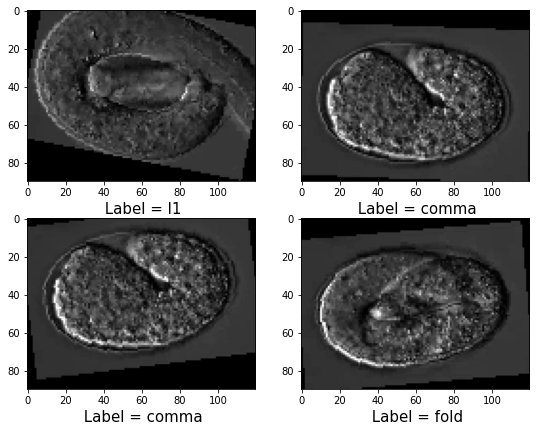

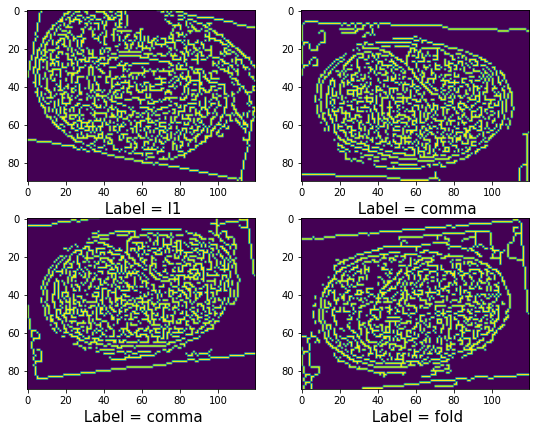

In [177]:
sample = next(iter(train_loader))
image_batch, labels = sample
fig, ax = plt.subplots(2,2, figsize = (9,7))
c = 0
for i in range (2):
    for j in range (2):
        image_np = image_batch[c].squeeze(0).squeeze(0).numpy()
        ax[i,j].imshow(image_np, cmap = "gray")
        x =  " Label = " + str(classes[int(labels[c].item())])
        ax[i,j].set_xlabel(x, fontsize= 15)
        c += 1

image_batch_canny = batch_to_canny(image_batch)

fig, ax = plt.subplots(2,2, figsize = (9,7))
c = 0
for i in range (2):
    for j in range (2):
        image_np = image_batch_canny[c].cpu().squeeze(0).squeeze(0).numpy()
        ax[i,j].imshow(image_np)
        x =  " Label = " + str(classes[int(labels[c].item())])
        ax[i,j].set_xlabel(x, fontsize= 15)
        c += 1

In [0]:
def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(7,7))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize = 23)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 24 )
    plt.xlabel('Predicted label', fontsize = 24)
    plt.show()

def confusion_matrix_finder(cellnet, val_loader, combined = False):
    y_true = []
    y_pred = []
    cellnet.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        
        for batch in val_loader:
            x_val, y_val = batch
            if combined == True:
                pred = cellnet(x_val.cuda(), x_val.cuda())  # pred
            else:
                pred = cellnet(x_val.cuda())  # pred
            y_pred.extend(torch.argmax(pred.cpu(),dim = 1).float().numpy().flatten())
            y_true.extend(y_val.cpu().numpy().flatten())
        return y_true, y_pred


##  Defining the training and the testing loops for the single and the combined network(s)
* functions ending with the  `_combined()` suffix are meant for the combined CNN with two smaller but different architectures in parallel with the same input
> the combined CNN takes input as `combined_model(x,x)` instead of te regular `model(x)`, this was done so that it can be scaled later on to take in two different pictures as input.

In [0]:
def calculate_accuracy_on_validation_set(val_loader, cellnet):
    
    cellnet.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in val_loader:
            x_val, y_val = batch
            pred = cellnet(x_val.cuda())  # pred()
            scores = ([i.item() for i in (torch.eq(torch.argmax(pred.cpu(),dim = 1).float(), y_val.squeeze(-1)))])
            for m in scores:
                total+= 1 
                if m == True:
                    correct +=1 
        acc = (correct/total)*100
        return acc

def calculate_accuracy_combined_model(val_loader, cellnet):
    print("running benchmark...")
    with torch.no_grad():
        total = 0
        correct = 0
        for x_val, y_val in val_loader:
            total+= 1 
            y_val =  y_val.long()
            pred = cellnet(x_val.cuda(), x_val.cuda())  # pred 
            scores = ([i.item() for i in (torch.eq(torch.argmax(pred,dim = 1).float(), y_val))])
            for m in scores:
                total+= 1 
                if m == True:
                    correct +=1 
        acc = (correct/total)*100
        return acc
    

def train_step(x, y, cellnet, optimizer):
        optimizer.zero_grad()
        pred = cellnet(x.cuda())
        y = y.long().squeeze(-1)  ## fix size with squeeze(-1)
        loss = F.cross_entropy(pred.cpu(),y)
        loss.backward()
        optimizer.step()        
        return loss.item()

def train(cellnet, epochs, train_loader, val_loader, optimizer):
    start = time.process_time()
    losses = []
    val_losses = []
    times = []
    timed_val_losses = []

    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in val_loader:
                y_val = y_val.long().squeeze(-1)  ## fix size with squeeze(-1)

                yhat =cellnet(x_val.cuda())  # pred 
                val_loss = F.cross_entropy(yhat.cpu(), y_val)
                val_losses.append(val_loss.item())  ## metrics 
                
                timed_val_losses.append(val_loss.item())
                times.append(time.process_time()- start)
        cellnet.train()
        
        for x_batch, y_batch in tqdm(train_loader, desc = " Training batches : "):
                loss = train_step(x_batch, y_batch, cellnet, optimizer)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

    clear_output()
    vis_loss_multi_colors(losses, val_losses)
    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses, val_losses

   
def train_step_combined(x, y, model, optimizer):
        optimizer.zero_grad()
        pred = model(x.cuda(),x.cuda())
        y = y.long().squeeze(-1)  ## fix size with squeeze(-1)
        loss = F.cross_entropy(pred.cpu(),y)
        loss.backward()
        optimizer.step()
        return loss.item()

def train_combined_model(epochs, cellnet, optimizer, train_loader, val_loader):
    start = time.process_time()
    losses = []
    val_losses = []

    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in val_loader:
                y_val =  y_val.long().squeeze(-1)  ## fix size with squeeze(-1)
                yhat =cellnet(x_val.cuda(), x_val.cuda())  # pred 
                val_loss = F.cross_entropy(yhat.cpu(), y_val)
                val_losses.append(val_loss.item())  ## metrics 
        cellnet.train()
        for x_batch, y_batch in tqdm(train_loader, desc = " Training batches : "):
                loss = train_step_combined(x_batch, y_batch, cellnet, optimizer)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

    clear_output()
    vis_loss_multi_colors(losses, val_losses)
    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses, val_losses


## Building two small CNNs 
* `cellnet_1()` is a relatively wider and shallower network as compared to `cellnet_2()`
* Both of them have different kernel sizes as well
> This was intentionallly done in order to obtain two differrent confusion matrices

In [146]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(5,5)

        self.pool2 = nn.MaxPool2d(3,3)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(10, 10, 3)
        self.conv3 = nn.Conv2d(10, 10, 3)
        
        self.fc1 = nn.Linear(150, 110)
        self.fc2 = nn.Linear(110, 100)
        self.fc3 = nn.Linear(100, 4)

    def forward(self, x):
        x = batch_to_canny(x)

        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))      ## removed relu
        return x

cellnet_1 = Net()
cellnet_1 = cellnet_1.cuda()
optimizer = optim.Adam(cellnet_1.parameters(), lr = 0.001) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch
print(cellnet_1)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=150, out_features=110, bias=True)
  (fc2): Linear(in_features=110, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=4, bias=True)
)


In [147]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.pool = nn.MaxPool2d(3,3)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(4, 8, 5)

        self.fc1 = nn.Linear(704,200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 20)

        self.fc4 = nn.Linear(20, 4)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = (self.fc4(x))      ## removed relu
        return x

cellnet_2 = Net_2()

cellnet_2 = cellnet_2.cuda()
optimizer_2 = optim.Adam(cellnet_2.parameters(), lr = 0.001) 
scheduler = StepLR(optimizer_2, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch
print(cellnet_2)

Net_2(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=704, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=4, bias=True)
)


# Training the two smaller architectures for a few epochs and saving them


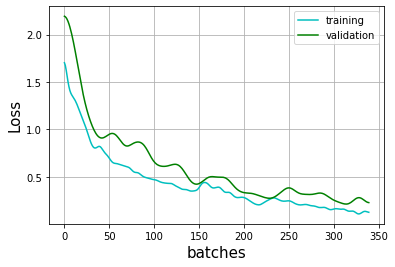

Time elapsed =  141.95602787100006  seconds


In [148]:
losses, val_losses = train(cellnet_1, 20, train_loader, val_loader, optimizer)

In [178]:
calculate_accuracy_on_validation_set(val_loader, cellnet_1)

96.0

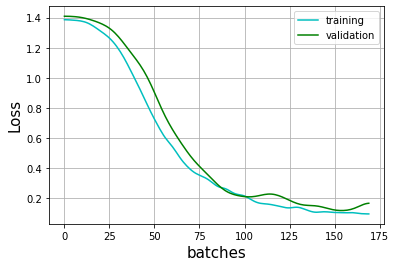

Time elapsed =  12.661834451000004  seconds


In [150]:
losses_2, val_losses_2 = train(cellnet_2, 10, train_loader, val_loader, optimizer_2)

In [179]:
print(calculate_accuracy_on_validation_set(val_loader, cellnet_2))

95.0


In [0]:
torch.save(cellnet_1.state_dict(), ROOT + "cellnet_1.pth")
torch.save(cellnet_2.state_dict(), ROOT + "cellnet_2.pth")

## Defining a new class which wraps the other two trained CNNs
* The `forward()` of this class contains the forward pass of the 2 smaller CNNs 
* The outputs from the 2 CNNs are concatenated and then passed through 2 more linear layers to shrink it to the desired size

In [0]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(8, 4)
        self.classifier2 = nn.Linear(4, 4)

    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1.cuda() ,x2.cuda()), dim=1)
        x = self.classifier(F.relu(x))
        x = self.classifier2(F.relu(x))
        return x

cellnet_2 = Net_2()
cellnet_1 = Net()
cellnet_1.load_state_dict(torch.load(ROOT + "cellnet_1.pth"))
cellnet_2.load_state_dict(torch.load(ROOT + "cellnet_2.pth"))
cellnet_1 = cellnet_1.cuda()
cellnet_2 = cellnet_2.cuda()
cellnet_1.eval()
cellnet_2.eval()

model = MyEnsemble(cellnet_1, cellnet_2)
model = model.cuda()
optimizer_3 = optim.Adam(model.parameters(), lr = 0.005) 
scheduler = StepLR(optimizer_3, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch

## freezing all the weights of the two smaller pre trained models in order to train only the last 2 linear layers
* this is similar to transfer learning, but we use 2 models to build up one bigger and more robust model.
* it's a bit hardcoded for now, need to put them all into a for loop soon enough

In [0]:
model.modelB.conv1.weight.requires_grad = False
model.modelB.conv1.bias.requires_grad = False
model.modelB.conv2.weight.requires_grad = False
model.modelB.conv2.bias.requires_grad = False

model.modelB.fc1.weight.requires_grad = False
model.modelB.fc1.bias.requires_grad = False


model.modelB.fc2.weight.requires_grad = False
model.modelB.fc2.bias.requires_grad = False

model.modelB.fc3.weight.requires_grad = False
model.modelB.fc3.bias.requires_grad = False

model.modelB.fc4.weight.requires_grad = False
model.modelB.fc4.bias.requires_grad = False

model.modelA.conv1.weight.requires_grad = False
model.modelA.conv1.bias.requires_grad = False
model.modelA.conv2.weight.requires_grad = False
model.modelA.conv2.bias.requires_grad = False
model.modelA.conv3.weight.requires_grad = False
model.modelA.conv3.bias.requires_grad = False

model.modelA.fc1.weight.requires_grad = False
model.modelA.fc1.bias.requires_grad = False

model.modelA.fc2.weight.requires_grad = False
model.modelA.fc2.bias.requires_grad = False

model.modelA.fc3.weight.requires_grad = False
model.modelA.fc3.bias.requires_grad = False

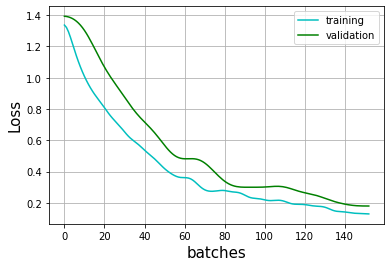

Time elapsed =  65.49755114999994  seconds


In [196]:
losses_c, val_losses_c = train_combined_model(9, model, optimizer_3, train_loader, val_loader)

In [0]:
y_true_c1, y_pred_c1 = confusion_matrix_finder(cellnet_1, val_loader)
y_true_c2, y_pred_c2 = confusion_matrix_finder(cellnet_2, val_loader)
y_true, y_pred = confusion_matrix_finder(model, val_loader, combined = True)

In [0]:
def accuracy(confusion_matrix):

    confusion_matrix = np.array(confusion_matrix)
    corrects = np.trace(confusion_matrix)
    total = np.sum(confusion_matrix)
    acc = (corrects/total)*100
    return acc

In [199]:
print ("Accuracy of model 1 = ", accuracy(confusion_matrix(y_true_c1, y_pred_c1)), "%")
print ("Accuracy of model 2 = ", accuracy(confusion_matrix(y_true_c2, y_pred_c2)), "%")
print ("Accuracy of the combined model = ", accuracy(confusion_matrix(y_true, y_pred)), "%")

Accuracy of model 1 =  88.0 %
Accuracy of model 2 =  91.0 %
Accuracy of the combined model =  99.0 %


In [0]:
torch.save(model.state_dict(), ROOT + "model.pth")
torch.save(model.state_dict(),"model.pth")

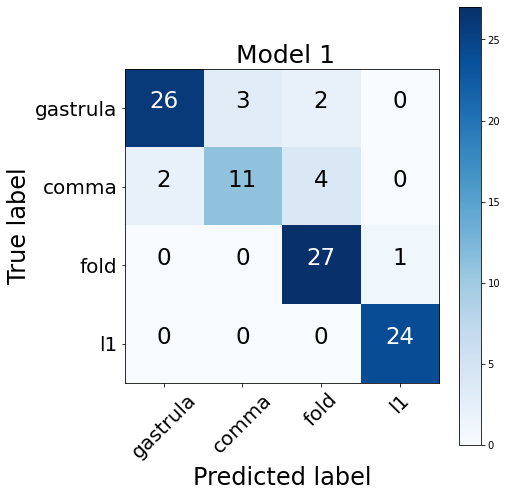

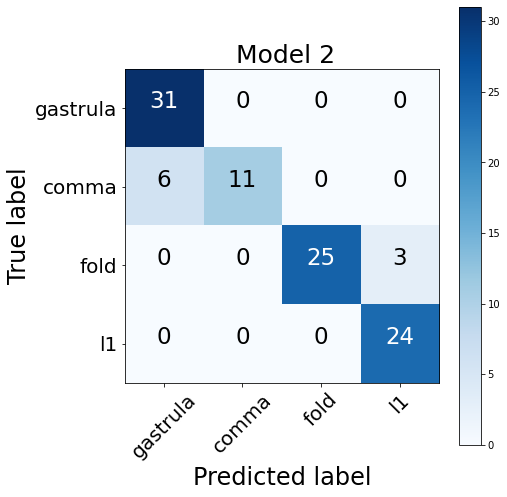

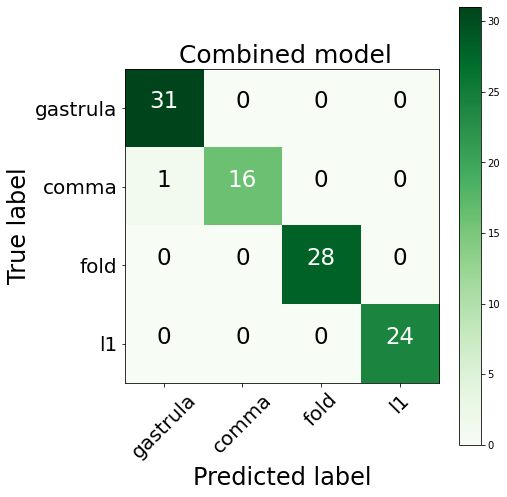

In [201]:
p1 = plot_confusion_matrix(confusion_matrix(y_true_c1, y_pred_c1), ("gastrula", "comma", "fold", "l1"), title = " Model 1")
p2 = plot_confusion_matrix(confusion_matrix(y_true_c2, y_pred_c2), ("gastrula", "comma", "fold", "l1"), title = " Model 2")
p3 = plot_confusion_matrix(confusion_matrix(y_true, y_pred), ("gastrula", "comma", "fold", "l1"), cmap = plt.cm.Greens, title = " Combined model")